In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from keras.applications import VGG16
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D,Multiply,Reshape
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 

from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101 # ResNet 101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3

In [5]:
# augmented dataset 
dataset_path = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset"

data = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            
            data.append({"image_path": image_path, "category": category})

df = pd.DataFrame(data)

output_csv = "dataset.csv"
df.to_csv(output_csv, index=False)

print(f"CSV file saved as {output_csv}")
df.head()

CSV file saved as dataset.csv


,image_path,category
0,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
1,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
2,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
3,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
4,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented


In [6]:
# original dataset 
o_dataset_path = "/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset"

data = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            
            data.append({"image_path": image_path, "category": category})

df_o = pd.DataFrame(data)

output_csv = "dataset_o.csv"
df_o.to_csv(output_csv, index=False)

print(f"CSV file saved as {output_csv}")
df_o.head()

CSV file saved as dataset_o.csv


,image_path,category
0,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
1,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
2,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
3,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented
4,/kaggle/input/augmented-alzheimer-mri-dataset/...,ModerateDemented


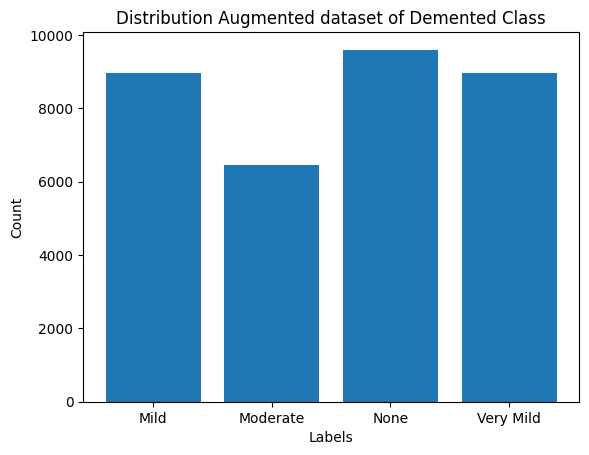

,category,image_path
0,MildDemented,8960
1,ModerateDemented,6464
2,NonDemented,9600
3,VeryMildDemented,8960


In [7]:
graph=df.groupby(["category"]).agg("count").reset_index()
# Counting the occurrences of each class label
category_counts = graph["category"].value_counts()
plt.bar( ['Mild','Moderate','None','Very Mild'],  graph["image_path"])
plt.xticks(['Mild','Moderate','None','Very Mild'])
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution Augmented dataset of Demented Class')
plt.show()
graph

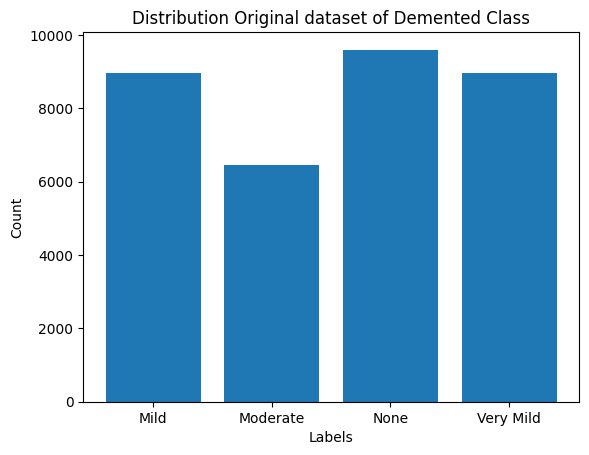

,category,image_path
0,MildDemented,8960
1,ModerateDemented,6464
2,NonDemented,9600
3,VeryMildDemented,8960


In [8]:
graph_o=df_o.groupby(["category"]).agg("count").reset_index()
# Counting the occurrences of each class label
category_counts = graph["category"].value_counts()
plt.bar( ['Mild','Moderate','None','Very Mild'],  graph["image_path"])
plt.xticks(['Mild','Moderate','None','Very Mild'])
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution Original dataset of Demented Class')
plt.show()
graph_o

In [9]:
def show_random_images(column, number_of_images_to_show=5,df=df, grey=False):
    categories = df["category"].unique()
    
    images_per_category = number_of_images_to_show
    
    plt.figure(figsize=(15, len(categories) * 5))
    for i, category in enumerate(categories):
        category_images = df[df["category"] == category][column].tolist()
        
        for j in range(min(len(category_images), images_per_category)):
            img_data = category_images[j]
            if column != "image_path":
                img = img_data
            else:
                img = cv2.imread(img_data)
                
            if column == "image_path":
                if grey:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(len(categories), images_per_category, i * images_per_category + j + 1)
            
            if grey:
                plt.imshow(img, cmap="gray")
            else:
                plt.imshow(img)
            
            plt.axis("off")
            plt.title(f"{category}")
    
    plt.tight_layout()
    plt.show()

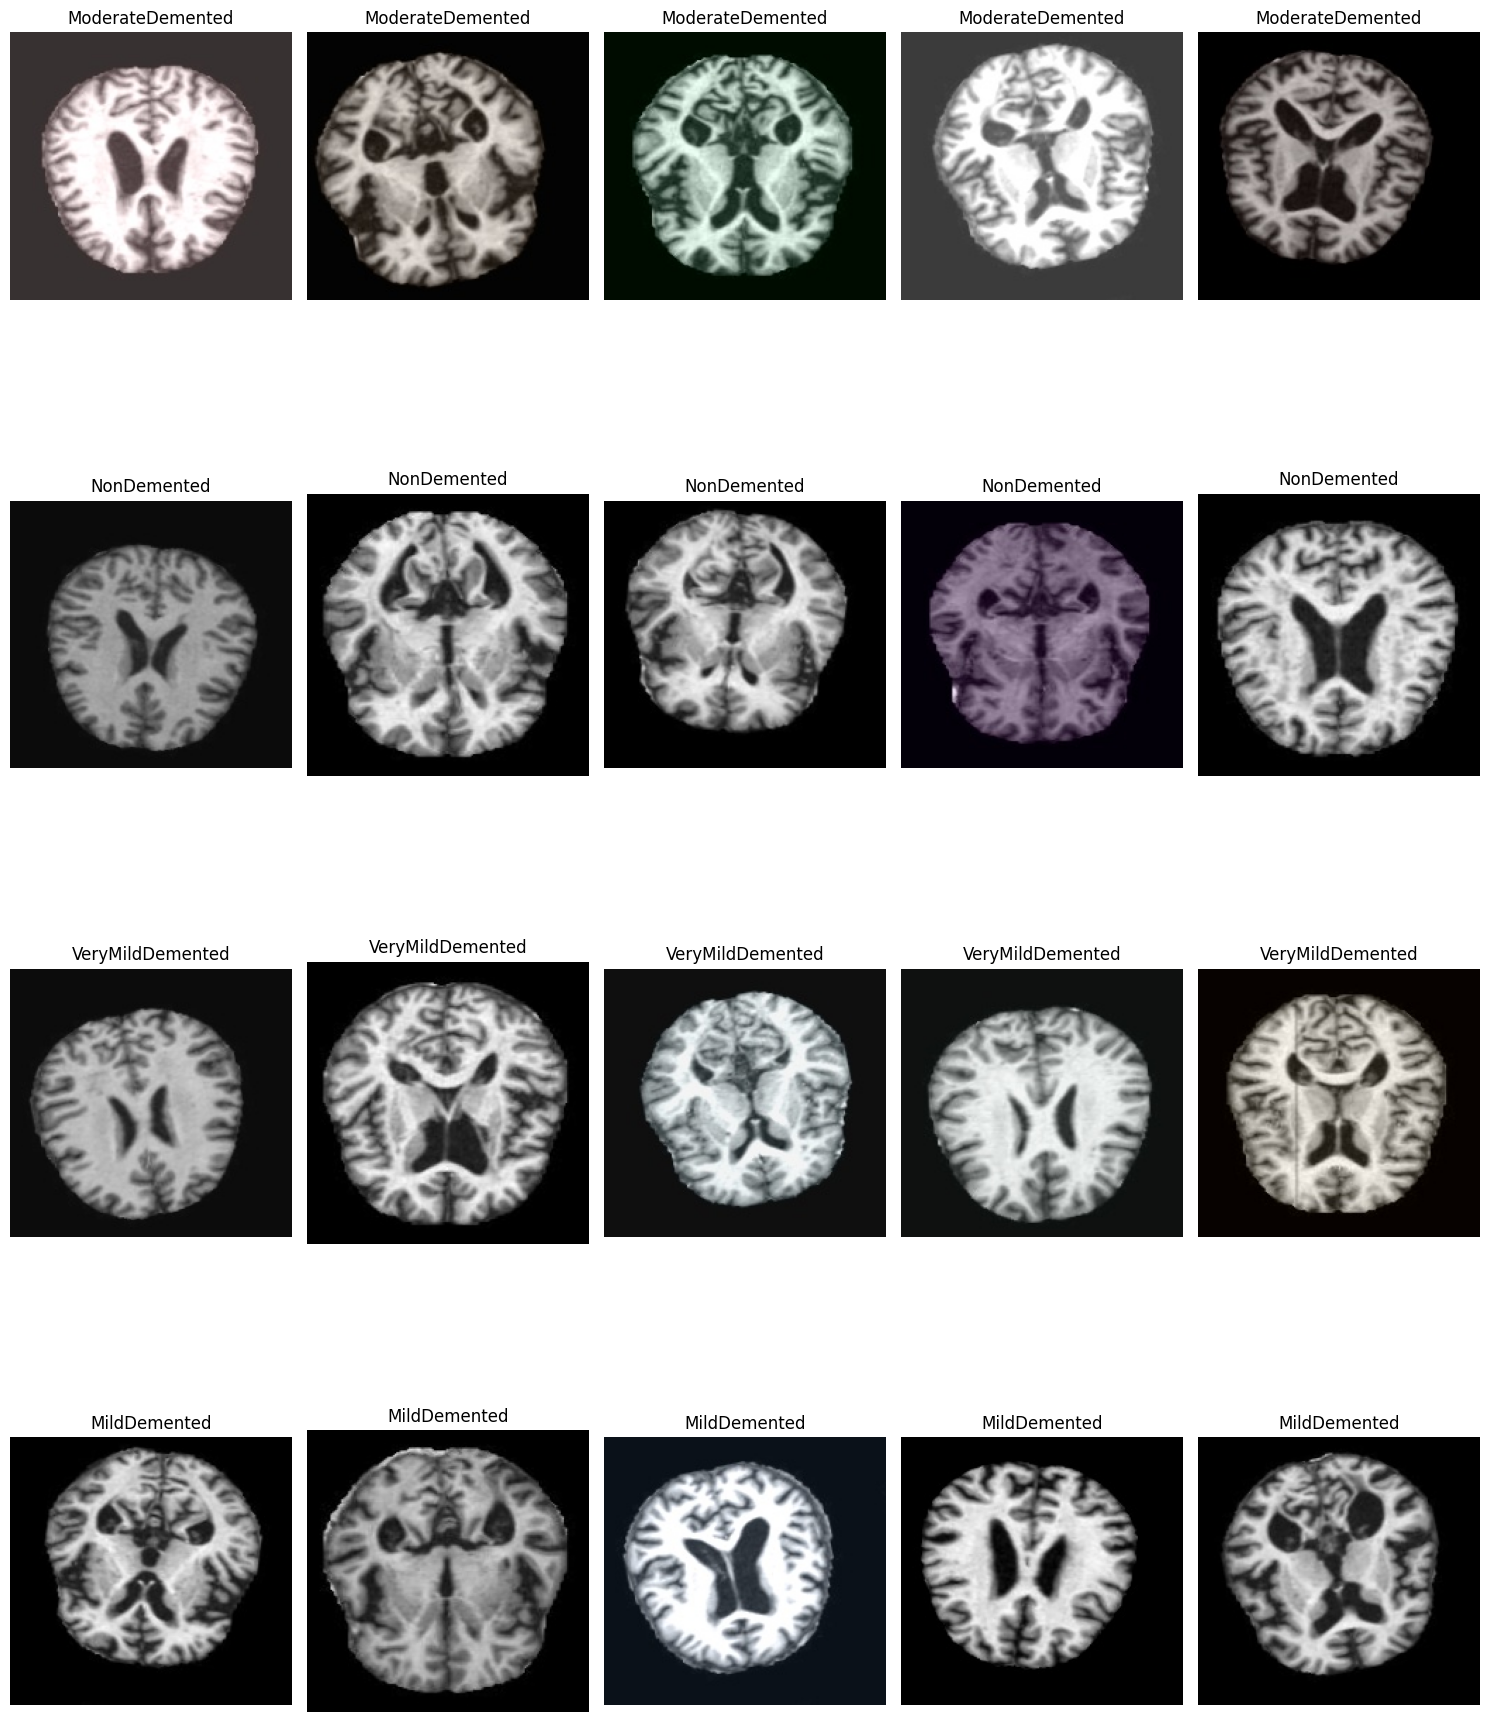

In [10]:
show_random_images("image_path", 5, df,False)

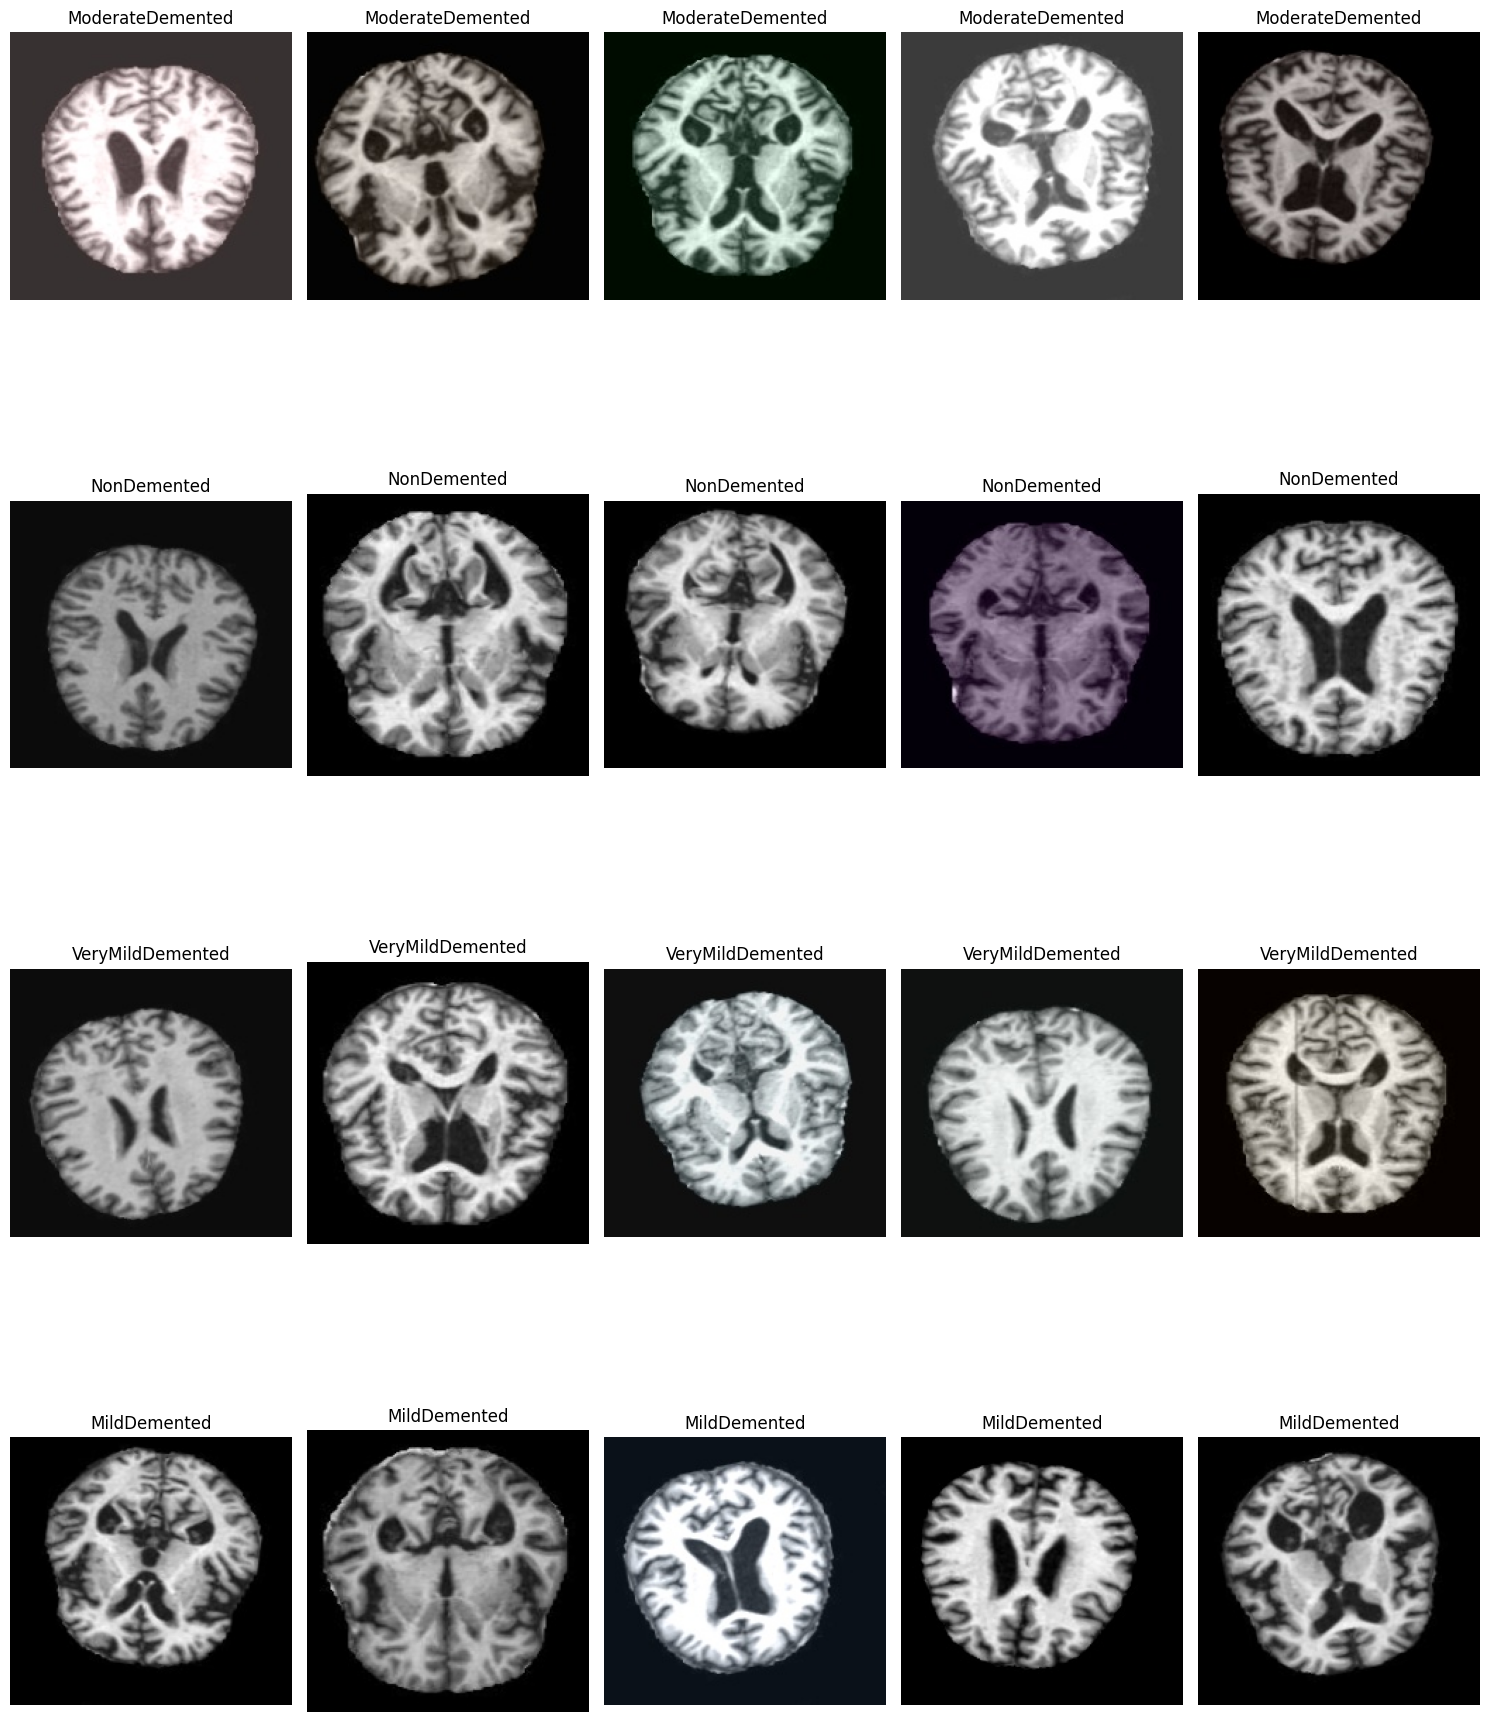

In [11]:
show_random_images("image_path", 5, df_o,False)

In [12]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']
IMG_SIZE = 128
IMAGE_SIZE = [ 128,  128]
DIM = (IMG_SIZE, IMG_SIZE)

In [13]:
datagen = IDG(rescale = 1./255, validation_split=0.1)

train_gen = datagen.flow_from_directory(directory=dataset_path,
                                             target_size=DIM,
                                             batch_size=128,
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True)

validation_gen = datagen.flow_from_directory(directory=dataset_path,
                                             target_size=DIM,
                                             batch_size=128,
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=True)

test_gen = datagen.flow_from_directory(directory=o_dataset_path,
                                             target_size=DIM,
                                             batch_size=128,
                                             class_mode='categorical')


Found 30586 images belonging to 4 classes.
Found 3398 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [14]:
# pretrain model
vgg = VGG16(input_shape=(128,128,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │          32,772 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,747,460 (56.26 MB)

 Trainable params: 32,772 (128.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
import time
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Epoch 1/50
 20/239 ━━━━━━━━━━━━━━━━━━━━ 44:27 12s/step - acc: 0.3514 - auc: 0.6065 - loss: 1.3822

In [ ]:
def plot_training_metrics(train_hist, model, test_gen_plot, y_actual, y_pred, classes, model_name):
    """
    Input: trained model history, model, test image generator, actual and predicted labels, class list
    Output: Plots loss vs epochs, accuracy vs epochs, confusion matrix
    """
    
    # Evaluate the results: 
    #. test_metrics[0] = loss, 
    #  test_metrics[1] = auc, 
    #  test_metrics[2] = acc
    # Evaluate the results:
    test_metrics = model.evaluate(test_gen_plot, verbose = False)
    AUC       = test_metrics[1]*100
    Acc       = test_metrics[2]*100 
    results_title =(f"\n Model AUC {AUC:.2f}%, Accuracy {Acc:.2f}% on Test Data\n")
    print(results_title.format(AUC, Acc))

    
    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))
# print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))

    # extract data from training history for plotting
    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    epochs          = range(1, len(history_dict['auc']) + 1)

    # get the min loss and max accuracy for plotting
    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)
    
    # create plots
    plt.subplots(figsize=(12,4))
    
    # plot loss by epochs
    plt.subplot(1,3,1)
    plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'cornflowerblue', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
    plt.legend()
        # plot accuracy by epochs
    plt.subplot(1,3,2)
    plt.plot(epochs, auc_values, 'bo',label = 'Training AUC')
    plt.plot(epochs, val_auc_values, 'cornflowerblue', label = 'Validation AUC')
    plt.plot(epochs,[AUC/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test AUC')
    plt.title('Validation AUC by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.axhline(y=max_auc,color='darkslategray', linestyle='--')
    plt.legend()
    
     # calculate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # create confusion matrix plot
    plt.subplot(1,3,3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title(f"Confusion Matrix \nAUC: {AUC:.2f}%")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
    threshold = cm.max() / 2.

    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f"{model_name}.pdf")

    plt.show()

In [ ]:
def prepare_for_test(model, test_gen):
    data, y_true = test_gen.next()
    y_pred_ = model.predict(data, batch_size = 64)
    y_pred = []
    for i in range(y_pred_.shape[0]):
        y_pred.append(np.argmax(y_pred_[i]))
        
    y_true = np.argmax(y_true, axis=1)
    
    return y_true, y_pred


In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "vgg16")


In [ ]:
# SAVE MODEL
model_dir = "./alzheimer_vgg19_model"
model.save(model_dir, save_format='h5')
np.save('my_vgg19_history.npy', history.history)
